In [23]:
from __future__ import print_function
import time,sys,statistics,csv
import numpy as np
import math
from pprint import pprint
import time
import copy
import matplotlib.pyplot as plt

In [3]:
#####################################  LOADING TRAIN X DATA   ####################################
f_x = open('./Data/train_x.txt','r')

X_train = np.zeros((64713,482))

line1 = f_x.readline()
counter = 0


while True:
    line1 = f_x.readline()
    
    if not line1:
        break
        
    counter+=1
    
    arr = line1.strip().split(' ')
    
    for i in range(len(arr)):
        index = int(arr[i].split(':')[0])
        value = int(float(arr[i].split(':')[1]))
        
        X_train[counter-1][index] = value
        
#####################################  LOADING TRAIN Y DATA   ####################################

f_y = open('./Data/train_y.txt','r')

Y_train = []

while True:
    line2 = f_y.readline()
    
    if not line2:
        break
        
    Y_train.append(int(line2))

Y_train = np.asarray(Y_train)


#####################################  LOADING VAL X DATA   ####################################

val_x = open('./Data/valid_x.txt','r')

X_val = np.zeros((21572,482))

line1 = val_x.readline()
counter = 0


while True:
    line1 = val_x.readline()
    
    if not line1:
        break
        
    counter+=1
    
    arr = line1.strip().split(' ')
    
    for i in range(len(arr)):
        index = int(arr[i].split(':')[0])
        value = int(float(arr[i].split(':')[1]))
        
        X_val[counter-1][index] = value
        
#####################################  LOADING VAL Y DATA   ####################################

val_y = open('./Data/valid_y.txt','r')

Y_val = []

while True:
    line2 = val_y.readline()
    
    if not line2:
        break
        
    Y_val.append(int(line2))

Y_val = np.asarray(Y_val)


#####################################  LOADING TEST X DATA   ####################################

test_x = open('./Data/test_x.txt','r')

X_test = np.zeros((21571,482))

line = test_x.readline()
counter = 0


while True:
    line1 = test_x.readline()
    
    if not line1:
        break
        
    counter+=1
    
    arr = line1.strip().split(' ')
    
    for i in range(len(arr)):
        index = int(arr[i].split(':')[0])
        value = int(float(arr[i].split(':')[1]))
        
        X_test[counter-1][index] = value
        
#####################################  LOADING TEST Y DATA   ####################################

test_y = open('./Data/test_y.txt','r')

Y_test = []

while True:
    line2 = test_y.readline()
    
    if not line2:
        break
        
    Y_test.append(int(line2))

Y_test = np.asarray(Y_test)

In [4]:
def entropy_func(c, n):
    """
    The math formula
    """
    return -(c*1.0/n)*np.log2(c*1.0/n)

In [5]:
def entropy_cal(c1, c2):
    """
    Returns entropy of a group of data
    c1: count of one class
    c2: count of another class
    """
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

In [6]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

In [10]:
def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/Fasle, and y_true can be multi class
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [11]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.trees = {}
        self.copy = {}
        self.no_nodes = 0
    
    def fit(self, x, y, par_node={}, depth=0):
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            self.no_nodes+=1
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    def find_best_split_of_all(self, x, y):
        col = None
        min_entropy = 1
        cutoff = None
#         count = 0
        for i, c in enumerate(x.T):
            if np.median(c)==0.0:
                continue
            else:
                entropy, cur_cutoff = self.find_split(c, y)
                if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                    return i, cur_cutoff, entropy
                elif entropy <= min_entropy:
                    min_entropy = entropy
                    col = i
                    cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_split(self, col, y):
        min_entropy = 10
        n = len(y)
        cutoff = np.median(col)
        y_predict = col < cutoff
        my_entropy = get_entropy(y_predict, y)

        return my_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)                                       

In [13]:
def predict(tree, x):
    results = np.array([0]*len(x))
    for i, c in enumerate(x):
        results[i] = get_prediction(tree, c)
    return results

def get_prediction(cur_layer, row):
#         cur_layer = self.trees
    while cur_layer.get('left')!=None and cur_layer.get('right')!=None:
#         print(cur_layer)
        if row[cur_layer['index_col']] < cur_layer['cutoff']:
            cur_layer = cur_layer['left']
        else:
            cur_layer = cur_layer['right']
    else:
        return cur_layer.get('val')

In [19]:
def val_ac(tree):
    res = predict(tree, X_val)

    correct = 0

    for i in range(len(res)):
        if res[i]==Y_val[i]:
            correct+=1
    
    return correct,len(res)

In [20]:
start = time.time()
num_of_nodes = [0]
train_acc = [0.]
val_acc = [0.]
test_acc = [0.]


for depth in range(2,32,2):
    clf = DecisionTreeClassifier(max_depth=depth)
    m = clf.fit(X_train,Y_train)
    end = time.time()
    print("Time Elapsed for depth", depth,":", end-start,'Sec')
    print("Number of nodes", clf.no_nodes)
    num_of_nodes.append(clf.no_nodes)

    res = predict(m,X_train)

    correct = 0

    for i in range(len(res)):
        if res[i]==Y_train[i]:
            correct+=1

    print('Training Accuracy for depth', depth,' is ', (correct/len(res))*100,'%')
    train_acc.append((correct/len(res))*100)
    
    true, length = val_ac(m)
            
    print('Validation Accuracy for depth', depth,' is ', true/length*100,'%') 
    val_acc.append(true/length*100)
    
    res = predict(m,X_test)

    correct = 0

    for i in range(len(res)):
        if res[i]==Y_test[i]:
            correct+=1

    print('Test Accuracy for depth', depth,' is ', (correct/len(res))*100,'%')
    
    test_acc.append((correct/len(res))*100)
    
    print('===========================NEW TREE================================')
    print()

Time Elapsed for depth 2 : 65.42293286323547 Sec
Number of nodes 3
Training Accuracy for depth 2  is  63.92842241898846 %
Validation Accuracy for depth 2  is  63.61950676803263 %
Test Accuracy for depth 2  is  63.659542904825926 %
===========================NEW TREE================================

Time Elapsed for depth 4 : 203.588525056839 Sec
Number of nodes 15
Training Accuracy for depth 4  is  68.59827237185728 %
Validation Accuracy for depth 4  is  68.19024661598368 %
Test Accuracy for depth 4  is  68.23049464558899 %
===========================NEW TREE================================

Time Elapsed for depth 6 : 416.86126375198364 Sec
Number of nodes 59
Training Accuracy for depth 6  is  71.70274906123963 %
Validation Accuracy for depth 6  is  71.18950491377711 %
Test Accuracy for depth 6  is  71.40605442492235 %
===========================NEW TREE================================

Time Elapsed for depth 8 : 715.4815859794617 Sec
Number of nodes 222
Training Accuracy for depth 8  

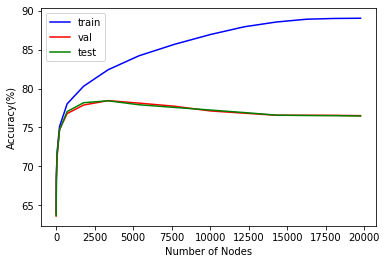

In [42]:
#Plotting num of nodes vs accuracy

plt.plot(num_of_nodes[1:], train_acc[1:], 'b',label='train')
plt.plot(num_of_nodes[1:], val_acc[1:],'r',label='val')
plt.plot(num_of_nodes[1:], test_acc[1:],'g',label='test')
plt.legend(loc='upper left')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy(%)')
plt.show()

In [46]:
#============================================PRUNING TREE=============================================

orig_tree = copy.deepcopy(m)      
pruning_tree = copy.deepcopy(m)
prev = copy.deepcopy(m)
train_for_graph = []
val_for_graph = []
test_for_graph = []

def pruning(node):
    if 'left' in node.keys() and 'right' in node.keys():
        if (node['left']!=None and node['right']!=None):
            #Postorder traversal
            pruning(node['left'])
            pruning(node['right'])

            stor_left = node['left']
            stor_right = node['right']
            prev = copy.deepcopy(pruning_tree)
    #         pprint(prev)
            node['left'] = None
            node['right'] = None

    #         pprint(m)

            tree_cor, len_cor = val_ac(pruning_tree)
            tree_prev, len_prev = val_ac(prev)

#             print(tree_cor)
#             print(tree_prev)

            if (tree_cor>tree_prev):
                val_for_graph.append(tree_cor/len_cor*100)
            
                res = predict(pruning_tree,X_train)

                correct = 0

                for i in range(len(res)):
                    if res[i]==Y_train[i]:
                        correct+=1

                train_for_graph.append(correct/len(res)*100)

                res = predict(pruning_tree,X_test)

                correct = 0

                for i in range(len(res)):
                    if res[i]==Y_test[i]:
                        correct+=1

                test_for_graph.append(correct/len(res)*100)
                


            else:
                node['left'] = stor_left
    #             print(node['left'])
                node['right'] = stor_right
    #             print(node['right'])
#                 print('Back to Same')

pruning(pruning_tree)

In [53]:
def change_indices(size):
    x_labels = []
    for i in range(size):
        x_labels.append(19755 - i)
    
    return x_labels

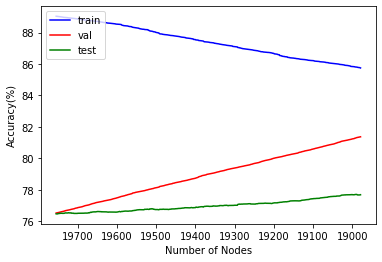

In [55]:
x_labels = change_indices(len(train_for_graph))

plt.plot(x_labels, train_for_graph, 'b',label='train')
plt.plot(x_labels, val_for_graph,'r',label='val')
plt.plot(x_labels, test_for_graph,'g',label='test')

plt.legend(loc='upper left')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy(%)')
ax = plt.gca()
ax.invert_xaxis()
plt.show()

In [57]:
true, length = val_ac(pruning_tree)
        
print('Validation Accuracy is ', true/length*100,'%')

Validation Accuracy is  81.3693676988689 %


In [58]:
res = predict(pruning_tree,X_train)
print(res)

correct = 0

for i in range(len(res)):
    if res[i]==Y_train[i]:
        correct+=1
        
print('Training Accuracy is ', (correct/len(res))*100,'%')

[0 0 0 ... 1 1 1]
Training Accuracy is  85.74938574938575 %


In [59]:
res = predict(pruning_tree,X_test)
print(res)

correct = 0

for i in range(len(res)):
    if res[i]==Y_test[i]:
        correct+=1
        
print('Test Accuracy is ', (correct/len(res))*100,'%')

[1 1 1 ... 0 1 0]
Test Accuracy is  77.68300032450975 %
